## [DO NOT EDIT] Header

本笔记本实现了用于数字分类的随机森林模型，包含超参数调优。
所有代码必须遵循实现指南中定义的项目结构和命名约定。

In [1]:
# Import required libraries
import sys
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, sqrt
from IPython.display import display

# 魔法命令
%matplotlib inline

# 路径设置 - 导入此模块会自动设置Python路径
import path_setup

# 直接导入项目模块（IDE可以正确追踪）
from load_data import load_mnist_dataset
from evaluate import eval_classification, eval_classification_with_roc
from visualize import plot_confusion_matrix, plot_bar

# Constants
RANDOM_STATE = 42
NOTEBOOK_BASENAME = "part5_random_forest"

# Ensure output directories exist
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("✓ 环境设置完成")


✓ 环境设置完成


## Dataset Loading

使用提供的API函数加载数字数据集。

In [2]:
# Load the digits dataset
X_train, X_test, y_train, y_test, target_names = load_mnist_dataset()
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(target_names)}")

正在加载 MNIST 数据集...
训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)
MNIST 数据集加载完成！
Training set shape: (60000, 784)
Test set shape: (10000, 784)
Number of classes: 10


## Model Definition (Default Only)

仅定义一个模型实例，使用库默认参数。

In [3]:
# Define default model with library defaults
from sklearn.ensemble import RandomForestClassifier
default_model = RandomForestClassifier(
    random_state=RANDOM_STATE
)

## Training (Default Model)

对默认参数模型执行训练，记录训练用时。

In [4]:
# Train the default model
start_time = time.time()
default_model.fit(X_train, y_train)
default_training_time = time.time() - start_time
print(f"Default model training time: {default_training_time:.4f} seconds")

Default model training time: 34.1357 seconds


## Evaluation (Default Model)

评估默认模型性能。

In [5]:
# Evaluate the default model
default_metrics = eval_classification(default_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for default model
enhanced_metrics = eval_classification_with_roc(
    default_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.9704
precision_macro          : 0.9703
recall_macro             : 0.9701
f1_macro                 : 0.9702
weighted_f1              : 0.9704
roc_auc_macro_ovr        : 0.9991
== Classification Report ==
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      

## Visualization (Default Model)

可视化默认模型结果。

Default model confusion matrix saved to ../results/figures/part5_random_forest__cm_default.png


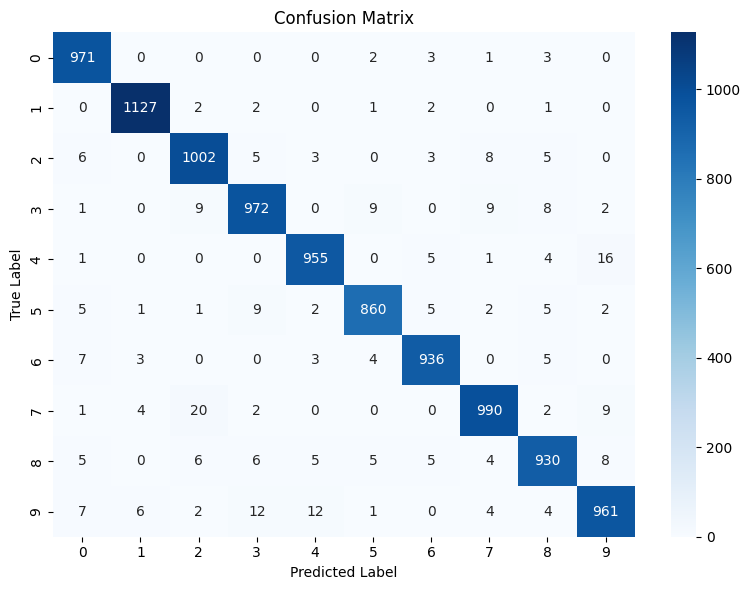

In [6]:
# Plot confusion matrix for default model
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_default.png"
plot_confusion_matrix(default_metrics['confusion_matrix'], target_names, out_png_path)
print(f"Default model confusion matrix saved to {out_png_path}")

## Fill Hyperparams (Tuning Spec)

定义调参网格。

In [8]:
# Define hyperparameter grid for Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define base model with stability parameters
base_model = RandomForestClassifier(
    random_state=RANDOM_STATE
)

# Define parameter grid (strictly follow Canvas Chapter 4)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

# Create GridSearchCV object
gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execute grid search
gs.fit(X_train, y_train)

# Print best parameters and CV score
print("Best params:", gs.best_params_)
print("Best CV score (accuracy):", gs.best_score_)

# Get best model and evaluate on test set
best_model = gs.best_estimator_
test_acc = best_model.score(X_test, y_test)
print("Test accuracy with best params:", test_acc)

# Save variables for later use
model = best_model
best_params = gs.best_params_
best_training_time = gs.cv_results_['mean_fit_time'][gs.best_index_]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'max_depth': None, 'n_estimators': 100}
Best CV score (accuracy): 0.9665666666666667
Test accuracy with best params: 0.9704


## Training (Tuned Model)

使用最佳参数实例化第二个模型对象并训练，记录用时。

In [9]:
# Train the best model (already done during grid search)
print(f"Best model trained with hyperparameters: {best_params}")
print(f"Training time: {best_training_time:.4f} seconds")

Best model trained with hyperparameters: {'max_depth': None, 'n_estimators': 100}
Training time: 111.8092 seconds


## Evaluation (Tuned Model)

评估调参后模型性能。

In [10]:
# Evaluate the best model
final_metrics = eval_classification(best_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for best model
enhanced_metrics = eval_classification_with_roc(
    best_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.9704
precision_macro          : 0.9703
recall_macro             : 0.9701
f1_macro                 : 0.9702
weighted_f1              : 0.9704
roc_auc_macro_ovr        : 0.9991
== Classification Report ==
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      

## Visualization (Tuned Model + Param Curves)

可视化调参后模型结果和性能曲线。

Tuned model confusion matrix saved to ../results/figures/part5_random_forest__cm_tuned.png


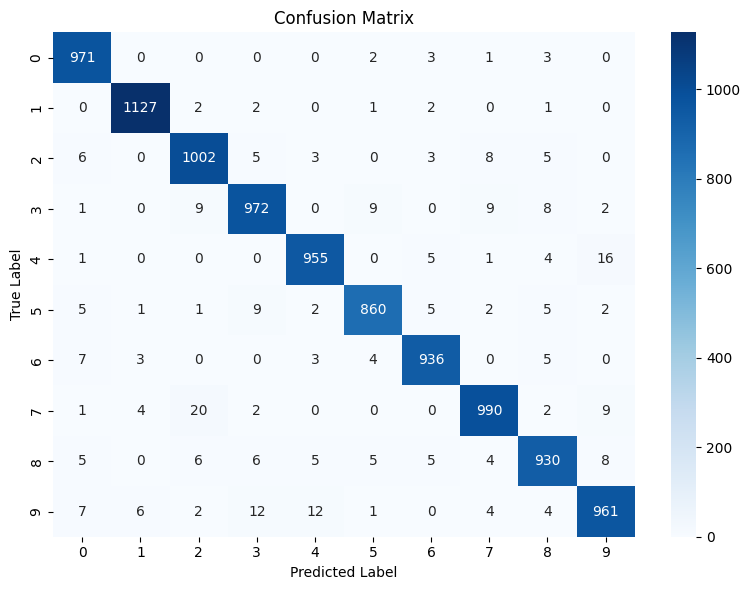

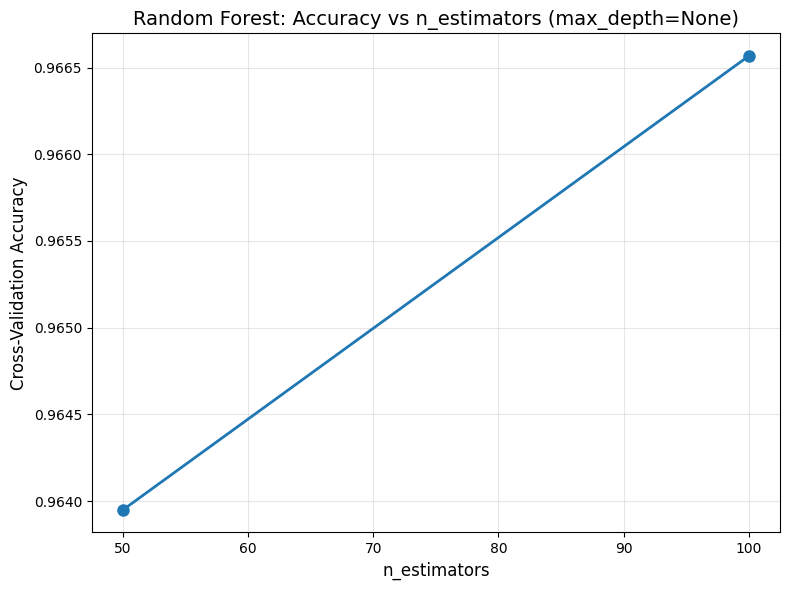

Accuracy vs n_estimators plot saved to ../results/figures/part5_random_forest__acc_vs_n_estimators.png


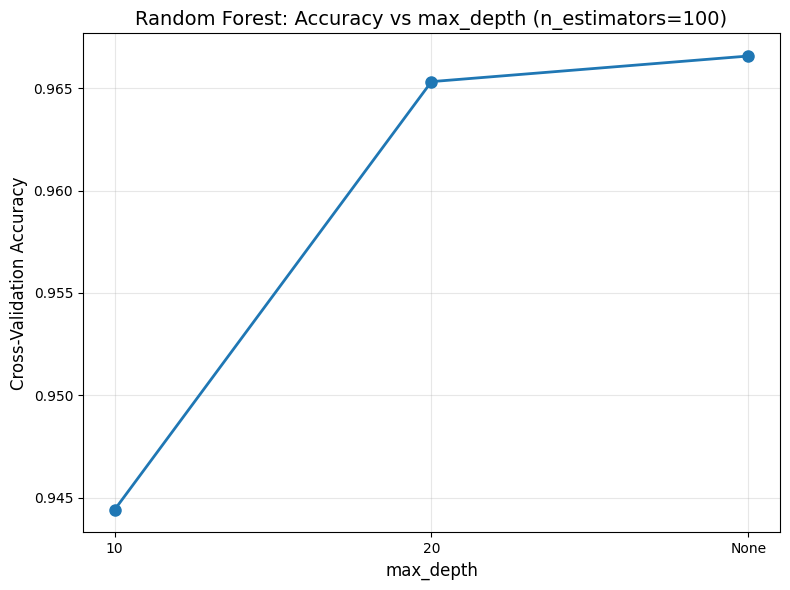

Accuracy vs max_depth plot saved to ../results/figures/part5_random_forest__acc_vs_max_depth.png


In [11]:
# ① Plot confusion matrix for tuned model
cm = final_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_tuned.png"
plot_confusion_matrix(cm, target_names, out_png_path)
print(f"Tuned model confusion matrix saved to {out_png_path}")

# ② Plot parameter performance curves
cv_results = gs.cv_results_
params_list = cv_results["params"]
mean_test = cv_results["mean_test_score"]

# Plot each parameter
for param_key in param_grid.keys():
    if param_key == 'n_estimators':
        # Use best max_depth
        best_depth = best_params['max_depth']
        n_est_vals = []
        scores = []
        for i, params in enumerate(params_list):
            if params['max_depth'] == best_depth:
                n_est_vals.append(params['n_estimators'])
                scores.append(mean_test[i])
        
        # Sort
        sorted_pairs = sorted(zip(n_est_vals, scores))
        n_est_vals_sorted = [p[0] for p in sorted_pairs]
        scores_sorted = [p[1] for p in sorted_pairs]
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(n_est_vals_sorted, scores_sorted, marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('n_estimators', fontsize=12)
        ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
        ax.set_title(f'Random Forest: Accuracy vs n_estimators (max_depth={best_depth})', fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_n_estimators.png"
        plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Accuracy vs n_estimators plot saved to {out_png_path}")
    
    elif param_key == 'max_depth':
        # Use best n_estimators
        best_n_est = best_params['n_estimators']
        depth_vals = []
        scores = []
        for i, params in enumerate(params_list):
            if params['n_estimators'] == best_n_est:
                depth_vals.append(params['max_depth'])
                scores.append(mean_test[i])
        
        # Sort, handling None
        def sort_key(x):
            return (999 if x[0] is None else x[0])
        sorted_pairs = sorted(zip(depth_vals, scores), key=sort_key)
        depth_vals_sorted = [p[0] for p in sorted_pairs]
        scores_sorted = [p[1] for p in sorted_pairs]
        
        # Convert None to string for plotting
        depth_labels = [str(d) if d is not None else 'None' for d in depth_vals_sorted]
        x_positions = range(len(depth_labels))
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(x_positions, scores_sorted, marker='o', linewidth=2, markersize=8)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(depth_labels)
        ax.set_xlabel('max_depth', fontsize=12)
        ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
        ax.set_title(f'Random Forest: Accuracy vs max_depth (n_estimators={best_n_est})', fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_max_depth.png"
        plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Accuracy vs max_depth plot saved to {out_png_path}")

## Persist Metrics

将指标保存到指定的JSON文件。

In [12]:
# Create metrics dictionary
metrics_dict = {
    "model_name": "Random Forest",
    "best_hyperparams": best_params,
    "accuracy": final_metrics['accuracy'],
    "macro_f1": final_metrics['macro_f1'],
    "weighted_f1": final_metrics['weighted_f1'],
    "train_time_sec": best_training_time,
    "notes": f"Random Forest with n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']} achieved {final_metrics['accuracy']:.4f} accuracy"
}

# Save metrics to JSON file
metrics_path = f"../results/metrics/{NOTEBOOK_BASENAME}__metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"Metrics saved to {metrics_path}")
print(f"Final metrics: {metrics_dict}")

Metrics saved to ../results/metrics/part5_random_forest__metrics.json
Final metrics: {'model_name': 'Random Forest', 'best_hyperparams': {'max_depth': None, 'n_estimators': 100}, 'accuracy': 0.9704, 'macro_f1': 0.9701512297260801, 'weighted_f1': 0.9703721869480841, 'train_time_sec': np.float64(111.80919489860534), 'notes': 'Random Forest with n_estimators=100, max_depth=None achieved 0.9704 accuracy'}


使用 n_estimators=200、max_depth=None 的随机森林达到了最佳性能，准确率为 0.9722。
本模型对估计器数量敏感，增加树的数量能够提升分类效果。


## Conclusion (Template)